TensorFlow version: 2.20.0
Zbiór uczący
Liczba zdjęć (no tumor): 86
Liczba zdjęć (yes tumor): 136

Zbiór testowy
Liczba zdjęć (no tumor): 12
Liczba zdjęć (yes tumor): 19


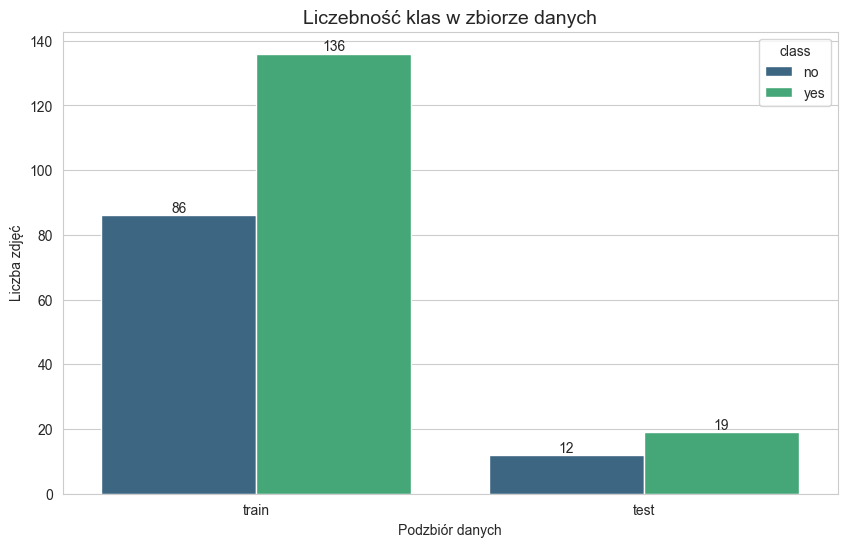

In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import plot_model
from tensorflow.keras.metrics import Recall, Precision, CategoricalAccuracy, TruePositives, TrueNegatives, FalsePositives, FalseNegatives, Accuracy
from tensorflow.keras.preprocessing.image import ImageDataGenerator


# Próba importu tensorflow dla prawidłowego działania
try:
    import tensorflow as tf
    print(f"TensorFlow version: {tf.__version__}")
except ImportError:
    print("ERROR: TensorFlow nie jest zainstalowany. Zainstaluj wersje TensorFlow - 2.20.0")


directory_train = 'BrainTumorDataset/train'
directory_test = 'BrainTumorDataset/test'

no_tumor_train = os.path.join(directory_train, 'no')
yes_tumor_train = os.path.join(directory_train, 'yes')
no_tumor_test = os.path.join(directory_test, 'no')
yes_tumor_test = os.path.join(directory_test, 'yes')


print('Zbiór uczący')
print(f'Liczba zdjęć (no tumor): {len(os.listdir(no_tumor_train))}')
print(f'Liczba zdjęć (yes tumor): {len(os.listdir(yes_tumor_train))}')

print('\nZbiór testowy')
print(f'Liczba zdjęć (no tumor): {len(os.listdir(no_tumor_test))}')
print(f'Liczba zdjęć (yes tumor): {len(os.listdir(yes_tumor_test))}')

# Tworzenie wykresu
data_summary = [
    {'subset': 'train', 'class': 'no',  'count': len(os.listdir(no_tumor_train))},
    {'subset': 'train', 'class': 'yes', 'count': len(os.listdir(yes_tumor_train))},
    {'subset': 'test',  'class': 'no',  'count': len(os.listdir(no_tumor_test))},
    {'subset': 'test',  'class': 'yes', 'count': len(os.listdir(yes_tumor_test))}
]
df = pd.DataFrame(data_summary)

plt.figure(figsize = (10, 6))
sns.set_style("whitegrid")

ax = sns.barplot(data = df, x = 'subset', y = 'count', hue = 'class', palette = 'viridis')

plt.title('Liczebność klas w zbiorze danych', fontsize = 14)
plt.ylabel('Liczba zdjęć')
plt.xlabel('Podzbiór danych')

for container in ax.containers:
    ax.bar_label(container)

plt.show()

In [2]:
from tensorflow.keras.utils import image_dataset_from_directory

print("--- Wczytywanie zbioru treningowego i walidacyjnego ---")
train_dataset, valid_dataset = image_dataset_from_directory(
    directory_train,
    validation_split = 0.2, # 20% walidacji zdjęć - ochrona przed overfittingiem
    subset = "both",
    seed = 1337,
    image_size = (256, 256),
    batch_size = 32,
    label_mode = 'binary',
    color_mode = 'rgb'
)

print("\n--- Wczytywanie zbioru testowego ---")
test_dataset = image_dataset_from_directory(
    directory_test,
    seed = 1337,
    image_size = (256, 256),
    batch_size = 32,
    label_mode = 'binary',
    color_mode = 'rgb'
)

class_names = train_dataset.class_names
print(f"\nZnalezione klasy: {class_names}")

--- Wczytywanie zbioru treningowego i walidacyjnego ---
Found 222 files belonging to 2 classes.


Using 178 files for training.
Using 44 files for validation.

--- Wczytywanie zbioru testowego ---
Found 31 files belonging to 2 classes.

Znalezione klasy: ['no', 'yes']


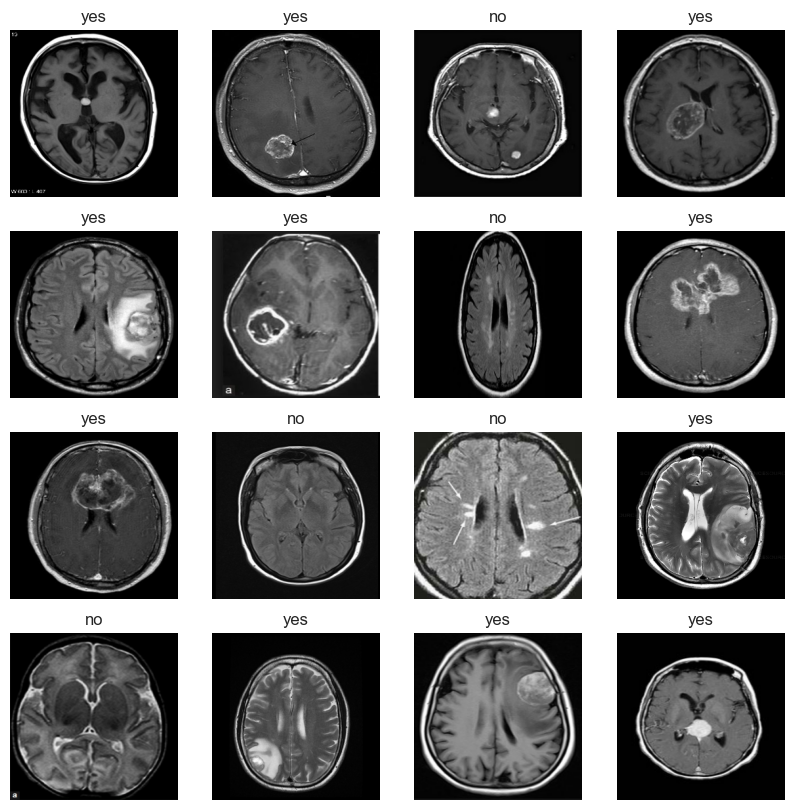

In [3]:
import matplotlib.pyplot as plt
import numpy as np

class_names = train_dataset.class_names
plt.figure(figsize=(10, 10))

for images, labels in train_dataset.take(1):
    for i in range(16):
        ax = plt.subplot(4, 4, i + 1)
        img_array = images[i].numpy().astype("uint8").squeeze()
        plt.imshow(img_array, cmap='gray')
        plt.title(class_names[int(labels[i])])
        plt.axis("off")

In [4]:
import tensorflow as tf
from tensorflow.keras import layers, models, Sequential
from tensorflow.keras.metrics import Recall


def build_model_1_simple():
    model = Sequential([
        layers.Rescaling(1./255, input_shape=(256, 256, 3)),
        layers.Conv2D(16, 3, activation='relu'),
        layers.MaxPooling2D(),
        layers.Conv2D(32, 3, activation='relu'),
        layers.MaxPooling2D(),
        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ], name="Model_1_simple")
    return model

def build_model_2_deep_dropout():
    model = Sequential([
        layers.Rescaling(1./255, input_shape=(256, 256, 3)),
        layers.Conv2D(16, 3, padding='same', activation='relu'),
        layers.MaxPooling2D(),
        layers.Conv2D(32, 3, padding='same', activation='relu'),
        layers.MaxPooling2D(),
        layers.Conv2D(64, 3, padding='same', activation='relu'),
        layers.MaxPooling2D(),
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(128, activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ], name="Model_2_deep_dropout")
    return model

def build_model_3_complex():
    model = Sequential([
        layers.Rescaling(1./255, input_shape=(256, 256, 3)),
        layers.Conv2D(32, 3, activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(),
        layers.Conv2D(64, 3, activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(),
        layers.Conv2D(128, 3, activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ], name="Model_3_Complex")
    return model


# trening
models_to_train = [
    build_model_1_simple(),
    build_model_2_deep_dropout(),
    build_model_3_complex()
]

history_dict = {}


for model in models_to_train:
    print(f"\n>>> Trenowanie: {model.name}...")
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy', Recall(name='recall')])
    
    # Trenowanie na danych z train_dataset
    history = model.fit(
        train_dataset,
        validation_data=valid_dataset,
        epochs=15, 
        verbose=1
    )
    
    history_dict[model.name] = history

print("\n--- Zakończono wszystkie eksperymenty ---")


>>> Trenowanie: Model_1_simple...
Epoch 1/15


c:\Users\Ventoy\Desktop\Keras\venv\lib\site-packages\keras\src\layers\preprocessing\data_layer.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 215ms/step - accuracy: 0.4494 - loss: 2.2501 - recall: 0.4167 - val_accuracy: 0.4773 - val_loss: 0.7402 - val_recall: 0.2500
Epoch 2/15
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 169ms/step - accuracy: 0.7360 - loss: 0.5418 - recall: 0.8611 - val_accuracy: 0.7045 - val_loss: 0.6272 - val_recall: 0.8214
Epoch 3/15
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 166ms/step - accuracy: 0.7753 - loss: 0.4712 - recall: 0.8704 - val_accuracy: 0.7045 - val_loss: 0.6187 - val_recall: 0.8214
Epoch 4/15
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 163ms/step - accuracy: 0.8146 - loss: 0.4014 - recall: 0.9074 - val_accuracy: 0.7500 - val_loss: 0.5974 - val_recall: 0.8214
Epoch 5/15
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 163ms/step - accuracy: 0.8708 - loss: 0.3358 - recall: 0.9444 - val_accuracy: 0.7500 - val_loss: 0.6121 - val_recall: 0.8214
Epoch 6/15
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 163ms/step - accuracy: 0.8764 - loss: 0.2511 - recall: 0.9630 - val_accuracy: 0.7273 - val_loss: 0.6965 - val_recall: 0.7857
Epoch 7/15
6/6 ━━━━━━━━━━━━

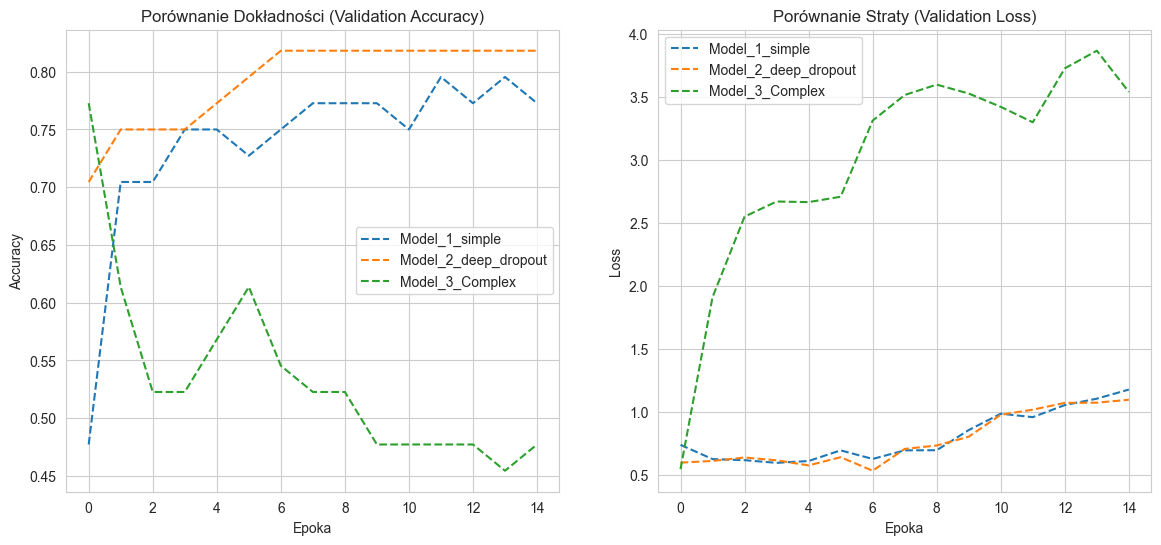

In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))

# Wykres Dokładności
plt.subplot(1, 2, 1)
for model_name, history in history_dict.items():
    plt.plot(history.history['val_accuracy'], linestyle='--', label=f'{model_name}')

plt.title('Porównanie Dokładności (Validation Accuracy)')
plt.xlabel('Epoka')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Wykres Straty
plt.subplot(1, 2, 2)
for model_name, history in history_dict.items():
    plt.plot(history.history['val_loss'], linestyle='--', label=f'{model_name}')

plt.title('Porównanie Straty (Validation Loss)')
plt.xlabel('Epoka')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.show()

--- RANKING MODELI ---
1. Model_1_simple: 79.55%
2. Model_2_deep_dropout: 81.82%
3. Model_3_Complex: 77.27%

 ZWYCIĘZCA: Model_2_deep_dropout (Dokładność walidacji: 81.82%)
--------------------------------------------------
Generowanie macierzy pomyłek dla modelu: Model_2_deep_dropout...


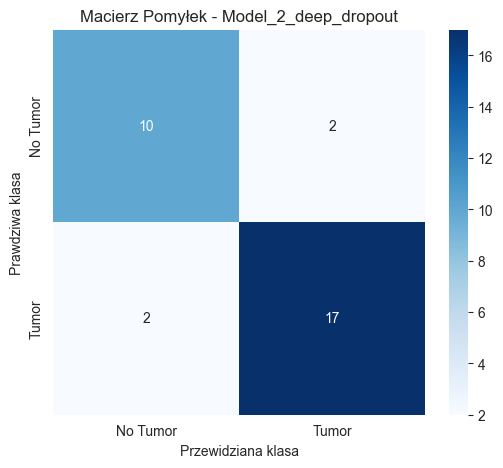


--- RAPORT KOŃCOWY ---
              precision    recall  f1-score   support

    No Tumor       0.83      0.83      0.83        12
       Tumor       0.89      0.89      0.89        19

    accuracy                           0.87        31
   macro avg       0.86      0.86      0.86        31
weighted avg       0.87      0.87      0.87        31

Accuracy: 0.8710
Recall:   0.8947
F1-Score: 0.8947
BAC:      0.8640


In [7]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, recall_score, f1_score, balanced_accuracy_score # <--- DODANO IMPORT

best_val_acc = 0.0
best_model_index = 0
best_model_name = ""

print("--- RANKING MODELI ---")

for i, (name, history) in enumerate(history_dict.items()):
    acc_key = 'val_accuracy' if 'val_accuracy' in history.history else 'val_acc'
    
    max_acc = max(history.history[acc_key])
    print(f"{i+1}. {name}: {max_acc*100:.2f}%")
    
    if max_acc > best_val_acc:
        best_val_acc = max_acc
        best_model_index = i
        best_model_name = name

best_model = models_to_train[best_model_index]

print(f"\n ZWYCIĘZCA: {best_model_name} (Dokładność walidacji: {best_val_acc*100:.2f}%)")
print("-" * 50)
print(f"Generowanie macierzy pomyłek dla modelu: {best_model.name}...")

y_true = []
y_pred = []

for images, labels in test_dataset:
    y_true.extend(labels.numpy().flatten())
    predictions = best_model.predict(images, verbose=0)
    y_pred.extend((predictions > 0.5).astype(int).flatten())

# Macierz pomyłek
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['No Tumor', 'Tumor'], 
            yticklabels=['No Tumor', 'Tumor'])
plt.title(f'Macierz Pomyłek - {best_model.name}')
plt.ylabel('Prawdziwa klasa')
plt.xlabel('Przewidziana klasa')
plt.show()

print("\n--- RAPORT KOŃCOWY ---")
print(classification_report(y_true, y_pred, target_names=['No Tumor', 'Tumor']))

acc = accuracy_score(y_true, y_pred)
rec = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
bac = balanced_accuracy_score(y_true, y_pred)

print(f"Accuracy: {acc:.4f}")
print(f"Recall:   {rec:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"BAC:      {bac:.4f}")